## <font color='darkblue'>Introduction</font>
> <font size='3ptx'>**Credit card fraud can be classified as an anomaly and using autoencoders implemented in Keras it is possible to detect fraud**</font>

I recently read an article called [**Anomaly Detection with Autoencoders**](https://medium.com/swlh/anomaly-detection-with-autoencoders-2bd23dedbd9e). The article was based on generated data, so it sounded like a good idea to apply this idea to a real-world fraud detection task and validate it.

I decided to use dataset from [**Credit Card Fraud Dataset From Kaggle**](https://www.kaggle.com/mlg-ulb/creditcardfraud):
> The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. **The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions**.

It is a very unbalanced dataset and **a good candidate to identify fraud through anomalies**. ([article source](https://towardsdatascience.com/applying-anomaly-detection-with-autoencoders-to-fraud-detection-feaaee6b5b09), [corresponding notebook](https://github.com/bgokden/anomaly-detection-with-autoencoders))

## <font color='darkblue'>Data Discovery</font>
**Let’s start with data discovery.** We are going to do a smaller plot after decreasing our dimensions from 30 to 3 with [**Principal Component Analysis**](https://en.wikipedia.org/wiki/Principal_component_analysis). This data has 32 columns where the first column is the time index, 29 unknown features, 1 transaction amount, and 1 class. I will ignore the time index since it is not stationary: ([download `credit_card_fraud_data.csv`](https://drive.google.com/file/d/1WElXtIPlyo75eqgHgzhlLxdS-9HH69Id/view?usp=sharing))

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt #繪圖用的模組
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import model_selection
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D #繪製3D座標的函式
from keras import models
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
from keras import activations
from keras.callbacks import EarlyStopping

RANDOM_STATE=42

[0.12769765 0.12418962 0.10439155]


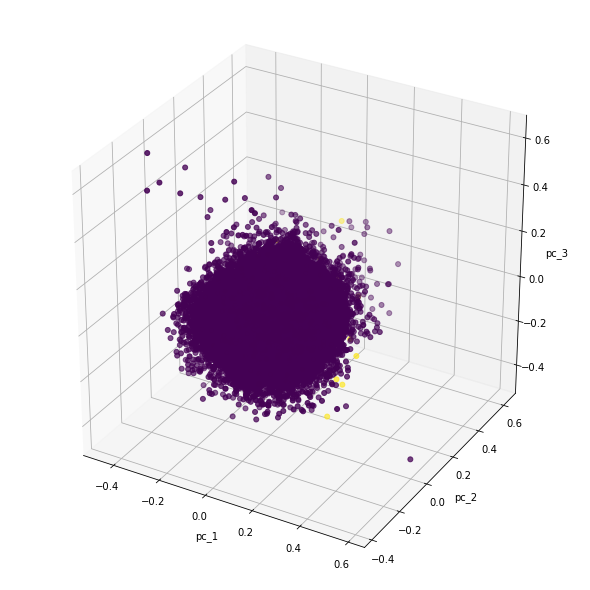

In [3]:
def show_pca_df(df):
    x = df[df.columns[1:30]].to_numpy()
    y = df[df.columns[30]].to_numpy()

    x = preprocessing.MinMaxScaler().fit_transform(x)
    pca = decomposition.PCA(n_components=3)
    pca_result = pca.fit_transform(x)
    print(pca.explained_variance_ratio_)

    pca_df = pd.DataFrame(data=pca_result, columns=['pc_1', 'pc_2', 'pc_3'])
    pca_df = pd.concat([pca_df, pd.DataFrame({'label': y})], axis=1)

    ax = Axes3D(plt.figure(figsize=(8, 8)))
    ax.scatter(xs=pca_df['pc_1'], ys=pca_df['pc_2'], zs=pca_df['pc_3'], c=pca_df['label'], s=25)
    ax.set_xlabel("pc_1")
    ax.set_ylabel("pc_2")
    ax.set_zlabel("pc_3")
    plt.show()
    
df = pd.read_csv('../../datas/credit_card_fraud_data.csv')
show_pca_df(df)

Your first reaction could be that there is **one cluster and this would be an easy task but fraud data is yellow points**! There are a few visible yellow points around large cluster. So let’s subsample the normal data while keeping the number of fraud data.

[0.21289524 0.14131858 0.0937648 ]


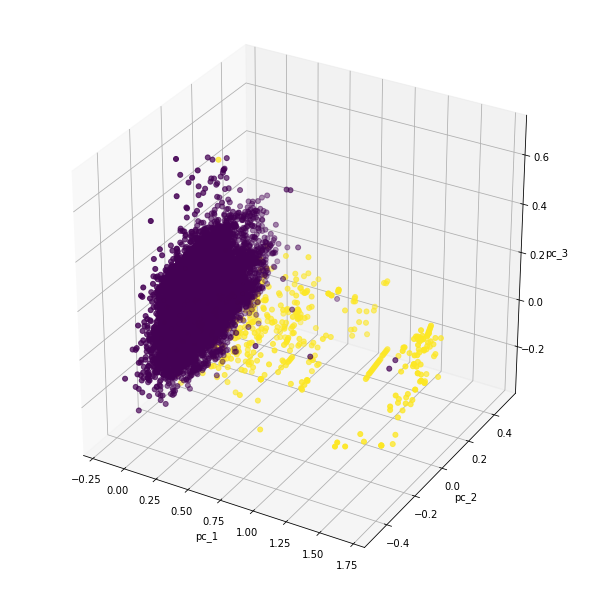

In [5]:
df_anomaly = df[df[df.columns[30]] > 0]
df_normal = df[df[df.columns[30]] == 0].sample(n=df_anomaly.size, random_state=RANDOM_STATE, axis='index')
df = pd.concat([ df_anomaly, df_normal])

show_pca_df(df)

## <font color='darkblue'>Autoencoder Training</font>
Now it is visible that normal transactions are clustered in a disk while frauded transactions are more distributed. We are going to build an autoencoder with **3 layer encoder and 2 layer decoder**:
![image](Images/1.PNG)
<br/>
The Autoencoder will encode our data into a subspace and decode the feature back while normalizing the data. **Our expectation is autoencoder will learn the features of normal transactions and the input will be similar to output when applied. For anomalies, the input and the output will be significantly different since it is unexpected data.**

The good part of this approach is it allows us to use [**unsupervised learning**](https://en.wikipedia.org/wiki/Unsupervised_learning) and we usually have plenty of normal transaction data. <font color='darkred'>**Data labeling is usually expensive, hard, and in some cases unavailable. Manual data labeling also includes human interaction which causes human biased implementations**</font>. It can be seen that in the model training we only use normal transaction features and not the labels.

Let’s load data and train our autoencoder:

In [8]:
df = pd.read_csv('../../datas/credit_card_fraud_data.csv')

x = df[df.columns[1:30]].to_numpy()
y = df[df.columns[30]].to_numpy()

# prepare data
df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,anomaly
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [9]:
normal_events = df[df['anomaly'] == 0]
abnormal_events = df[df['anomaly'] == 1]

normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']
abnormal_events = abnormal_events.loc[:, abnormal_events.columns != 'anomaly']

In [10]:
# scaling
scaler = preprocessing.MinMaxScaler()
scaler.fit(df.drop('anomaly', 1))

scaled_data = scaler.transform(normal_events)

In [25]:
# 80% percent of dataset is designated to training
train_data, test_data = model_selection.train_test_split(scaled_data, test_size=0.2)

n_features = train_data.shape[1]
train_data.shape

(45490, 29)

In [33]:
test_data.shape

(11373, 29)

In [38]:
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=20, activation=activations.relu, input_shape=[n_features,]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer=layers.Dense(units=10, activation=activations.relu))
encoder.add(layer=layers.Dense(units=5, activation=activations.relu))
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 20)                600       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 55        
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________


In [39]:
decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=10, activation=activations.relu, input_shape=[5,]))
decoder.add(layer=layers.Dense(units=20, activation=activations.relu))
decoder.add(layers.Dropout(0.1))
decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid))
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_16 (Dense)             (None, 20)                220       
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 29)                609       
Total params: 889
Trainable params: 889
Non-trainable params: 0
_________________________________________________________________


In [40]:
autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(
    loss=losses.MSE,
    optimizer=optimizers.Adam(),
    metrics=[metrics.mean_squared_error])

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 5)                 865       
_________________________________________________________________
decoder (Sequential)         (None, 29)                889       
Total params: 1,754
Trainable params: 1,754
Non-trainable params: 0
_________________________________________________________________


In [45]:
# train model
NB_EPOCH = 20
BATCH_SIZE = 50
SERIALIZED_MODEL_FILE = "model.h5"

es = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.00001, 
    patience=20, 
    restore_best_weights=True
)

history = autoencoder.fit(
    x=train_data, 
    y=train_data,
    epochs=NB_EPOCH,
    batch_size=BATCH_SIZE,
    shuffle=True,
    verbose=1,
    validation_data=(test_data, test_data), 
    callbacks=(es)
).history

Epoch 1/20
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/20
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/20
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/20
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/20
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/20
1422/1422 [==============================] - 4s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 7/20
1422/

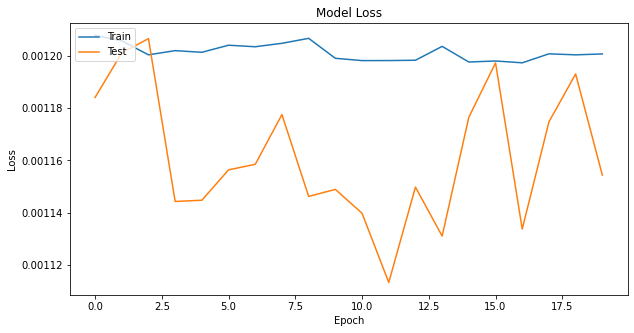

In [46]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

My model settles around validation loss of 1.2-03. (<font color='brown'>It can go as low as 1.1-03.</font>) Using this model, we will calculate the mean squared error (mse) for normal transactions and calculate a threshold value which is 95 percentile of all mse values.

In [48]:
train_predicted_x = autoencoder.predict(x=train_data)
train_events_mse = losses.mean_squared_error(train_data, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)
cut_off

0.00254769220482558

We found our threshold (<font color='brown'>cut_off</font>) as 0.002. We will consider a transaction as an anomaly if the mean squared error is higher than 0.002. Let’s select 100 fraud samples and 100 normal samples and plot it against the threshold:

In [49]:
plot_samples = 100
# normal event
real_x = test_data[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
    'mse': normal_events_mse,
    'n': np.arange(0, plot_samples),
    'anomaly': np.zeros(plot_samples)})

In [50]:
# abnormal event
abnormal_x = scaler.transform(abnormal_events)[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
    'mse': abnormal_events_mse,
    'n': np.arange(0, plot_samples),
    'anomaly': np.ones(plot_samples)})

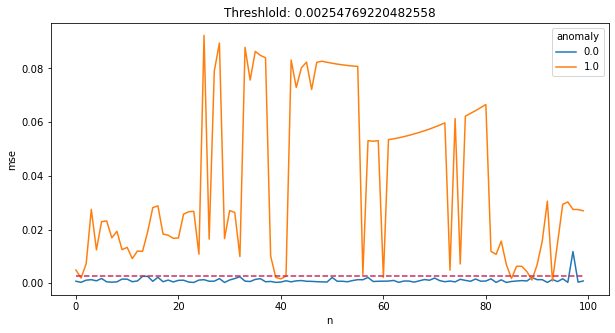

In [56]:
mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(
    xdata=np.arange(0, plot_samples),
    ydata=np.full(plot_samples, cut_off),
    color='#CC2B5E',
    linewidth=1.5,
    linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

It is visible that **most of the fraudulent transactions have high mean squared errors compared to normal transactions**. It looks very promising.

**We gave up on 5% of the normal transactions. There are still fraud transactions that are below the threshold. This can potentially be improved by using better feature extraction since it seems like some fraud data has very similar features to normal transactions**. Some valuable features for credit card fraud are the number of transactions in the previous hour/day/week, if the transaction initiated in a different country than the issued country.

## <font color='darkblue'>Supplement</font>

### <font color='darkgreen'>Future tasks:</font>
* Use a better model by using hyperparameter optimization.
* Analyze the data to understand the features.
* Compare these results to a common approach like SVM or K-means clustering.

### <font color='darkgreen'>Cited works:</font>
* [Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. **Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining** (CIDM), IEEE, 2015](https://www.researchgate.net/publication/283349138_Calibrating_Probability_with_Undersampling_for_Unbalanced_Classification)
* [Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. **Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications**,41,10,4915–4928,2014, Pergamon](https://www.researchgate.net/publication/260837261_Learned_lessons_in_credit_card_fraud_detection_from_a_practitioner_perspective)
* [Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. **Credit card fraud detection: a realistic modeling and a novel learning strategy**, IEEE transactions on neural networks and learning systems,29,8,3784–3797,2018,IEEE](https://www.researchgate.net/publication/319867396_Credit_Card_Fraud_Detection_A_Realistic_Modeling_and_a_Novel_Learning_Strategy)
* [Dal Pozzolo, Andrea **Adaptive Machine learning for credit card fraud detection** ULB MLG PhD thesis (supervised by G. Bontempi)](http://di.ulb.ac.be/map/adalpozz/pdf/Dalpozzolo2015PhD.pdf)
* [Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: **a scalable framework for streaming credit card fraud detection with Spark, Information fusion**,41, 182–194,2018,Elsevier](https://www.researchgate.net/publication/319616537_SCARFF_a_Scalable_Framework_for_Streaming_Credit_Card_Fraud_Detection_with_Spark)
* [Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. **Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics**, 5,4,285–300,2018,Springer International Publishing](https://www.researchgate.net/publication/332180999_Deep-Learning_Domain_Adaptation_Techniques_for_Credit_Cards_Fraud_Detection)
* [Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi **Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection**, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78–88, 2019](https://www.researchgate.net/publication/332180999_Deep-Learning_Domain_Adaptation_Techniques_for_Credit_Cards_Fraud_Detection)
* [Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi **Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences**, 2019](https://www.researchgate.net/publication/333143698_Combining_Unsupervised_and_Supervised_Learning_in_Credit_Card_Fraud_Detection)